# Global imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Qiskit
from qiskit import BasicAer
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_machine_learning.datasets import ad_hoc_data

# Scikit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn import metrics
from sklearn.svm import SVC
from collections import Counter

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores
# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qksvm.QKSVM import QSVM_QKT

seed = 12345

# Qiskit Ad Hoc dataset

In [2]:
np.random.seed(seed=77)
algorithm_globals.random_seed = seed

# generate the dataset
adhoc_dimension = 2
X, y, _, _, adhoc_total = ad_hoc_data(
    training_size=200,
    test_size=2,
    n=adhoc_dimension,
    gap=0.2,
    plot_data=False,
    one_hot=False,
    include_sample_total=True
)
y = 2*y-1

print(f"Dataset statistics: {Counter(y)}")

Dataset statistics: Counter({-1: 200, 1: 200})


In [118]:
train_size = 100
test_size = 50
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=42,
)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({-1: 50, 1: 50})
Testing target statistics: Counter({1: 25, -1: 25})


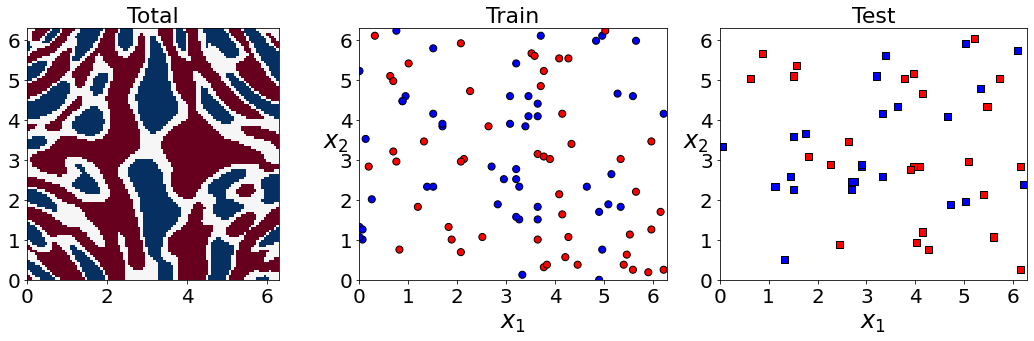

In [119]:
# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# visualize the dataset
xmin = 0; xmax = 2*np.pi
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=22)
ax1.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap=plt.cm.RdBu_r,
    extent=axes,
)

ax2.set_title("Train", fontsize=22)
plot_dataset(X_train, y_train, ax2, axes, marker='o', size=50, stepsize=1.0)
ax2.grid(False)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='s', size=50, stepsize=1.0)
ax3.grid(False)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

## Visualize the classifier

In [120]:
def plot_results(clf, N=20):
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap=plt.cm.RdBu_r,
        extent=axes,
    )
    plot_predictions(clf, axs[1], axes, N=N)
    plot_dataset(X_test, y_test, axs[1], axes, marker='s', size=50, stepsize=1.0)
    plot_decisions(clf, axs[2], axes, N=N)
    plot_dataset(X_test, y_test, axs[2], axes, marker='s', size=50, stepsize=1.0)
    plt.tight_layout()
    plt.show()   

# RBF kernel

Best grid search parameters: {'C': 1, 'gamma': 10.0}
Best training score: 0.73

Train set:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.98

Test set:
   Balanced accuracy:  0.78
                  F1:  0.78
             ROC_AUC:  0.91
                 MCC:  0.56


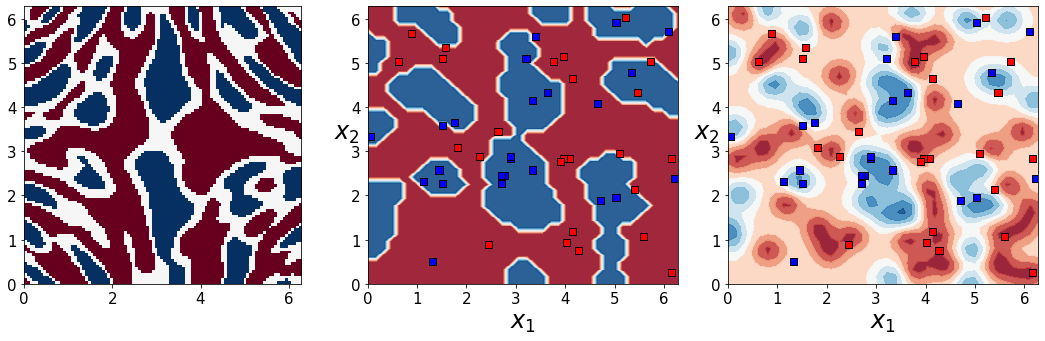

In [121]:
np.random.seed(seed)

param_grid = {
    "gamma": [0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
    "C": [1, 5, 10, 20, 50, 100, 1000],
}

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
)
clf.fit(X_train, y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

scores_ = get_scores(clf.best_estimator_, X_train, y_train)
print_scores(scores_, title='Train set:')

scores_ = get_scores(clf.best_estimator_, X_test, y_test)
print_scores(scores_, title='Test set:')

plot_results(clf.best_estimator_, N=40)

In [117]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

param_grid = {
    "gamma": [0.001, 0.01, 0.1, 1.0, 5.0, 8.0, 9.0, 10.0, 11.0],
    "C": [1, 5, 10, 20, 50, 100, 1000],
}

_train_size = 200
_test_size = 50
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=_train_size, test_size=_test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        clf = GridSearchCV(
            estimator=SVC(kernel='rbf'),
            param_grid=param_grid,
            scoring='balanced_accuracy',
            n_jobs=1,
            refit=True,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=_seed),
        )

        clf.fit(X[train,:], y[train])

        train_scores = get_scores(clf.best_estimator_, X[train,:], y[train])
        test_scores = get_scores(clf.best_estimator_, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_clf = clf.best_estimator_

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.96

Train set:
   Balanced accuracy:  1.00 +- 0.00
                  F1:  1.00 +- 0.00
             ROC_AUC:  1.00 +- 0.00
                 MCC:  0.99 +- 0.01

Test set:
   Balanced accuracy:  0.87 +- 0.05
                  F1:  0.87 +- 0.05
             ROC_AUC:  0.95 +- 0.03
                 MCC:  0.75 +- 0.11


# QKT SVM

     ┌────────────┐              ┌──────────┐ ┌──────────┐ ┌────────────┐               ┌──────────┐ ┌───────────┐ »
q_0: ┤ Ry(x[0]*α) ├──■────────■──┤ Rz(θ[0]) ├─┤ Rx(θ[4]) ├─┤ Ry(x[0]*α) ├──■────────■───┤ Rz(θ[8]) ├─┤ Rx(θ[12]) ├─»
     ├────────────┤  │        │  ├──────────┤ ├──────────┤ ├────────────┤  │        │   ├──────────┤ ├───────────┤ »
q_1: ┤ Ry(x[1]*α) ├──■──■─────┼──┤ Rz(θ[1]) ├─┤ Rx(θ[5]) ├─┤ Ry(x[1]*α) ├──■──■─────┼───┤ Rz(θ[9]) ├─┤ Rx(θ[13]) ├─»
     ├────────────┤     │     │  ├──────────┤ ├──────────┤ ├────────────┤     │     │  ┌┴──────────┤ ├───────────┤ »
q_2: ┤ Ry(x[0]*α) ├─────■──■──┼──┤ Rz(θ[2]) ├─┤ Rx(θ[6]) ├─┤ Ry(x[0]*α) ├─────■──■──┼──┤ Rz(θ[10]) ├─┤ Rx(θ[14]) ├─»
     ├────────────┤        │  │  ├──────────┤ ├──────────┤ ├────────────┤        │  │  ├───────────┤ ├───────────┤ »
q_3: ┤ Ry(x[1]*α) ├────────■──■──┤ Rz(θ[3]) ├─┤ Rx(θ[7]) ├─┤ Ry(x[1]*α) ├────────■──■──┤ Rz(θ[11]) ├─┤ Rx(θ[15]) ├─»
     └────────────┘              └──────────┘ └──────────┘ └────

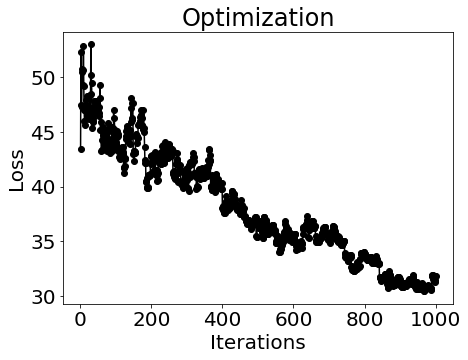


Train scores:
   Balanced accuracy:  0.98
                  F1:  0.98
             ROC_AUC:  1.00
                 MCC:  0.96

Test scores:
   Balanced accuracy:  0.74
                  F1:  0.74
             ROC_AUC:  0.81
                 MCC:  0.48


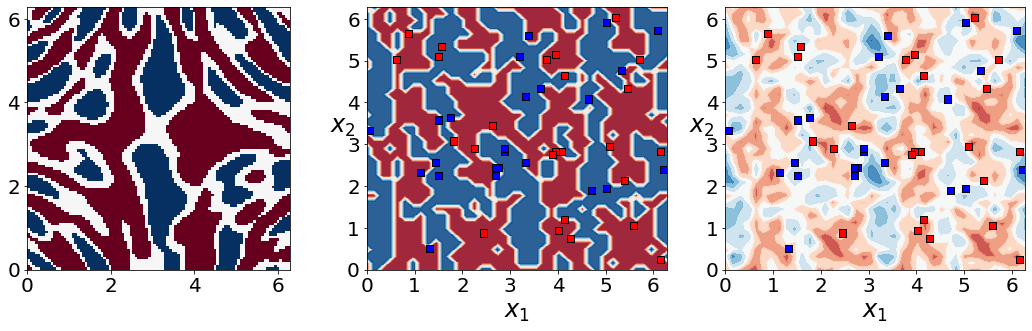

In [176]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=16,
    gates=['RY', 'CZ', 'rz', 'rx'], entanglement='ring',
    repeat=True,
)
# ending layer
for i in range(fm.num_qubits):
    fm.ry(fm.encod_params[i%fm.num_features], i)
print(fm.draw(plot_barriers=False, fold=120))

fm.assign_parameters({fm.alpha: 2.0}, inplace=True)

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=1000,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌──────────┐ ┌──────────┐           ┌────────────┐ ┌──────────┐  ┌──────────┐           ┌────────────┐ 
q_0: ┤ Rx(θ[0]) ├─┤ Rz(θ[3]) ├──■─────■──┤ Ry(x[0]*α) ├─┤ Rx(θ[6]) ├──┤ Rz(θ[9]) ├──■─────■──┤ Ry(x[1]*α) ├─
     ├──────────┤ ├──────────┤  │     │  ├────────────┤ ├──────────┤ ┌┴──────────┤  │     │  ├────────────┤ 
q_1: ┤ Rx(θ[1]) ├─┤ Rz(θ[4]) ├──■──■──┼──┤ Ry(x[1]*α) ├─┤ Rx(θ[7]) ├─┤ Rz(θ[10]) ├──■──■──┼──┤ Ry(x[0]*α) ├─
     ├──────────┤ ├──────────┤     │  │  ├────────────┤ ├──────────┤ ├───────────┤     │  │  ├────────────┤ 
q_2: ┤ Rx(θ[2]) ├─┤ Rz(θ[5]) ├─────■──■──┤ Ry(x[0]*α) ├─┤ Rx(θ[8]) ├─┤ Rz(θ[11]) ├─────■──■──┤ Ry(x[1]*α) ├─
     └──────────┘ └──────────┘           └────────────┘ └──────────┘ └───────────┘           └────────────┘ 


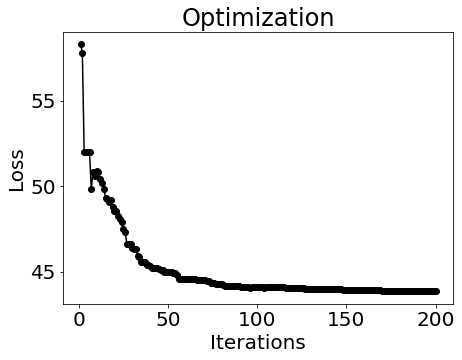


Train scores:
   Balanced accuracy:  0.84
                  F1:  0.84
             ROC_AUC:  0.92
                 MCC:  0.68

Test scores:
   Balanced accuracy:  0.78
                  F1:  0.78
             ROC_AUC:  0.88
                 MCC:  0.56


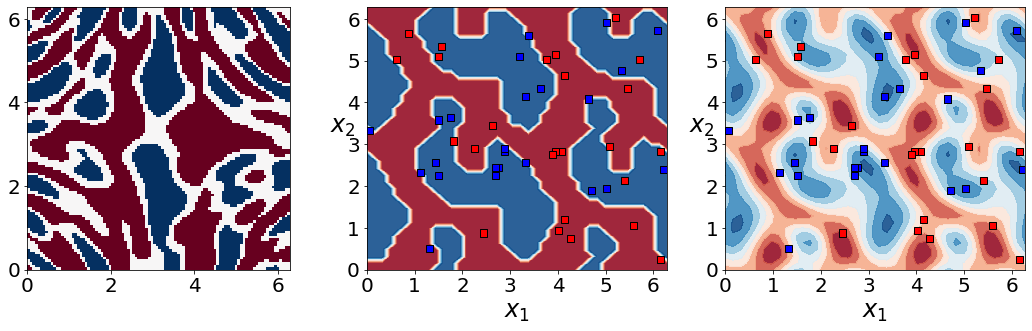

In [169]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=3,
    num_layers=2,
    gates=['rx', 'rz', 'cz', 'RY'], entanglement='ring',
    repeat=True,
)
# ending layer
# for i in range(fm.num_qubits):
#     fm.ry(fm.encod_params[i%fm.num_features], i)
print(fm.draw(plot_barriers=False, fold=120))

fm.assign_parameters({fm.alpha: 2.0}, inplace=True)

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=200,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌────────────┐                                                                                                   »
q_0: ┤ Ry(x[0]*α) ├───────■───────────────────────────────────────────────────────────────────────────────────────────»
     ├────────────┤ ┌─────┴──────┐                                                                                    »
q_1: ┤ Ry(x[1]*α) ├─┤ Rz(x[0]*α) ├──────■─────────────────────────────────────────────────────────────────────────────»
     ├────────────┤ └────────────┘┌─────┴──────┐                                                                      »
q_2: ┤ Ry(x[0]*α) ├───────────────┤ Rz(x[1]*α) ├──────■───────────────────────────────────────────────────────────────»
     ├────────────┤               └────────────┘┌─────┴──────┐                                                        »
q_3: ┤ Ry(x[1]*α) ├─────────────────────────────┤ Rz(x[0]*α) ├──────■─────────────────────────────────────────────────»
     ├────────────┤                     

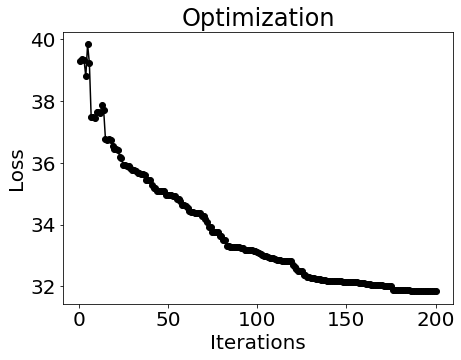


Train scores:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.98

Test scores:
   Balanced accuracy:  0.88
                  F1:  0.88
             ROC_AUC:  0.95
                 MCC:  0.76


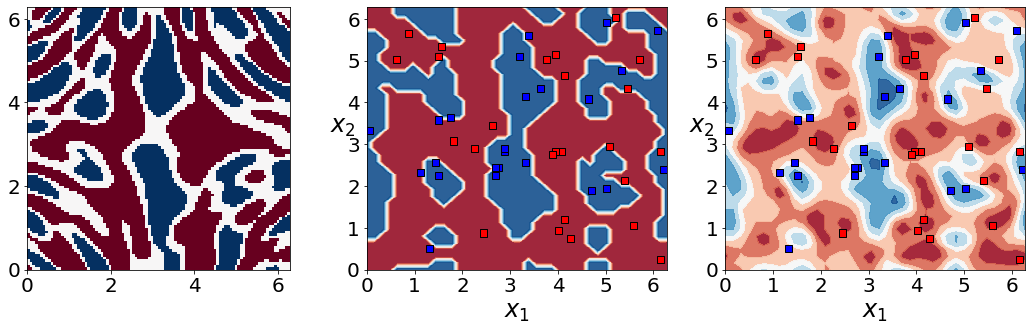

In [155]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['RY', 'CRZ', 'rz', 'rx', ], entanglement='ring',
    repeat=True,
)
# ending layer
for i in range(fm.num_qubits):
    fm.ry(fm.encod_params[i%fm.num_features], i)
print(fm.draw(plot_barriers=False, fold=120))

fm.assign_parameters({fm.alpha: 2.0}, inplace=True)

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=200,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌────────────┐                                                                                                   »
q_0: ┤ Ry(x[0]*α) ├───────■───────────────────────────────────────────────────────────────────────────────────────────»
     ├────────────┤ ┌─────┴──────┐                                                                                    »
q_1: ┤ Ry(x[1]*α) ├─┤ Rz(x[0]*α) ├──────■─────────────────────────────────────────────────────────────────────────────»
     ├────────────┤ └────────────┘┌─────┴──────┐                                                                      »
q_2: ┤ Ry(x[0]*α) ├───────────────┤ Rz(x[1]*α) ├──────■───────────────────────────────────────────────────────────────»
     ├────────────┤               └────────────┘┌─────┴──────┐                                                        »
q_3: ┤ Ry(x[1]*α) ├─────────────────────────────┤ Rz(x[0]*α) ├──────■─────────────────────────────────────────────────»
     ├────────────┤                     

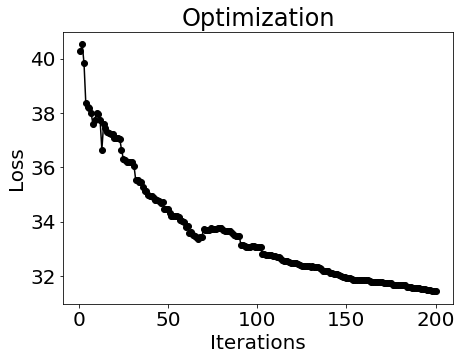


Train scores:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.98

Test scores:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.92
                 MCC:  0.60


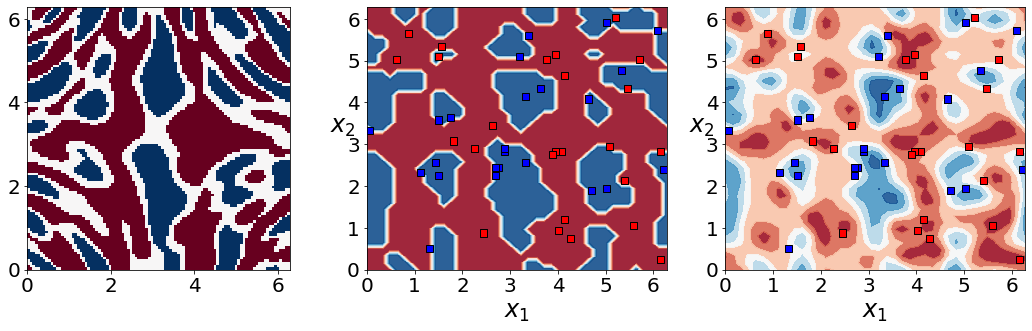

In [156]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['RY', 'CRZ', 'rz', 'ry', 'rz'], entanglement='ring',
    repeat=True,
)
# ending layer
for i in range(fm.num_qubits):
    fm.ry(fm.encod_params[i%fm.num_features], i)
print(fm.draw(plot_barriers=False, fold=120))

fm.assign_parameters({fm.alpha: 2.0}, inplace=True)

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=200,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌───┐ ┌────────────┐ ┌──────────┐                                                                       »
q_0: ┤ H ├─┤ Rz(x[0]*α) ├─┤ Ry(θ[0]) ├───────■───────────────────────────────────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤ ┌─────┴──────┐                                                        »
q_1: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Ry(θ[1]) ├─┤ Rz(x[0]*α) ├──────■─────────────────────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤ └────────────┘┌─────┴──────┐                                          »
q_2: ┤ H ├─┤ Rz(x[0]*α) ├─┤ Ry(θ[2]) ├───────────────┤ Rz(x[1]*α) ├──────■───────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤               └────────────┘┌─────┴──────┐                            »
q_3: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Ry(θ[3]) ├─────────────────────────────┤ Rz(x[0]*α) ├──────■─────────────────────»
     ├───┤ ├────────────┤ ├──────────┤                             └────────────┘┌─────┴──────┐              »
q

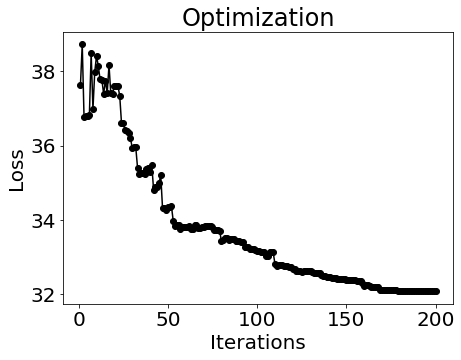


Train scores:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.98

Test scores:
   Balanced accuracy:  0.88
                  F1:  0.88
             ROC_AUC:  0.92
                 MCC:  0.76


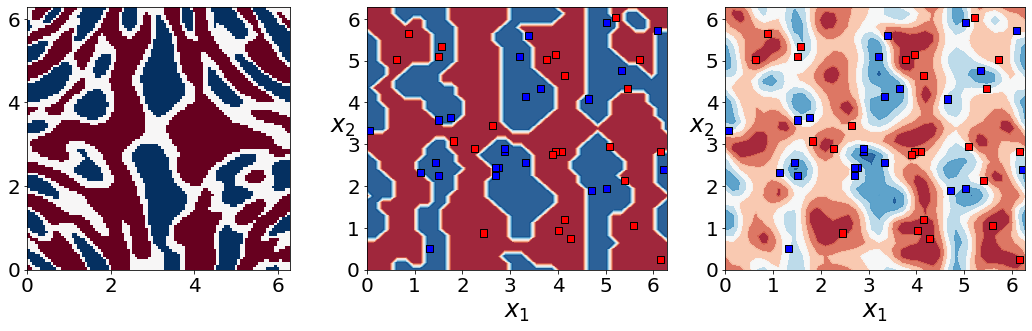

In [157]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['H', 'RZ', 'ry', 'CRZ'], entanglement='ring',
    repeat=True,
)

print(fm.draw(plot_barriers=False, fold=120))

fm.assign_parameters({fm.alpha: 2.0}, inplace=True)

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=200,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌───┐ ┌────────────┐ ┌──────────┐  ┌──────────┐                                                         »
q_0: ┤ H ├─┤ Rz(x[0]*α) ├─┤ Ry(θ[0]) ├──┤ Rz(θ[8]) ├───────■─────────────────────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤  ├──────────┤ ┌─────┴──────┐                                          »
q_1: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Ry(θ[1]) ├──┤ Rz(θ[9]) ├─┤ Rz(x[0]*α) ├──────■───────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤ ┌┴──────────┤ └────────────┘┌─────┴──────┐                            »
q_2: ┤ H ├─┤ Rz(x[0]*α) ├─┤ Ry(θ[2]) ├─┤ Rz(θ[10]) ├───────────────┤ Rz(x[1]*α) ├──────■─────────────────────»
     ├───┤ ├────────────┤ ├──────────┤ ├───────────┤               └────────────┘┌─────┴──────┐              »
q_3: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Ry(θ[3]) ├─┤ Rz(θ[11]) ├─────────────────────────────┤ Rz(x[0]*α) ├──────■───────»
     ├───┤ ├────────────┤ ├──────────┤ ├───────────┤                             └────────────┘┌─────┴──────┐»
q

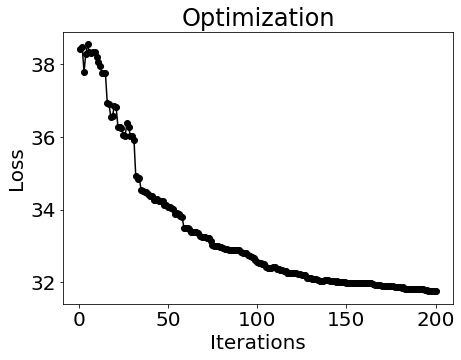


Train scores:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.98

Test scores:
   Balanced accuracy:  0.88
                  F1:  0.88
             ROC_AUC:  0.95
                 MCC:  0.76


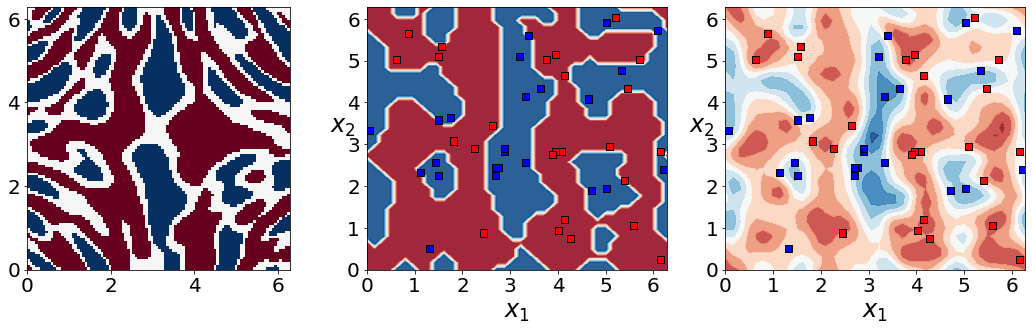

In [158]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['H', 'RZ', 'ry', 'rz', 'CRZ'], entanglement='ring',
    repeat=True,
)

print(fm.draw(plot_barriers=False, fold=120))

fm.assign_parameters({fm.alpha: 2.0}, inplace=True)

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=200,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌──────────────┐                          ┌──────────┐  ┌──────────┐ ┌──────────────┐                          »
q_0: ┤ Ry(2.0*x[0]) ├──■────────────────────■──┤ Rz(θ[0]) ├──┤ Rx(θ[8]) ├─┤ Ry(2.0*x[0]) ├──■────────────────────■──»
     ├──────────────┤  │                    │  ├──────────┤  ├──────────┤ ├──────────────┤  │                    │  »
q_1: ┤ Ry(2.0*x[1]) ├──■──■─────────────────┼──┤ Rz(θ[1]) ├──┤ Rx(θ[9]) ├─┤ Ry(2.0*x[1]) ├──■──■─────────────────┼──»
     ├──────────────┤     │                 │  ├──────────┤ ┌┴──────────┤ ├──────────────┤     │                 │  »
q_2: ┤ Ry(2.0*x[0]) ├─────■──■──────────────┼──┤ Rz(θ[2]) ├─┤ Rx(θ[10]) ├─┤ Ry(2.0*x[0]) ├─────■──■──────────────┼──»
     ├──────────────┤        │              │  ├──────────┤ ├───────────┤ ├──────────────┤        │              │  »
q_3: ┤ Ry(2.0*x[1]) ├────────■──■───────────┼──┤ Rz(θ[3]) ├─┤ Rx(θ[11]) ├─┤ Ry(2.0*x[1]) ├────────■──■───────────┼──»
     ├──────────────┤           │           │  ├────────

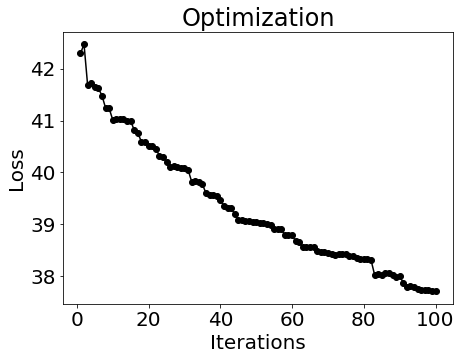


Train scores:
   Balanced accuracy:  0.94
                  F1:  0.94
             ROC_AUC:  0.99
                 MCC:  0.88

Test scores:
   Balanced accuracy:  0.76
                  F1:  0.76
             ROC_AUC:  0.85
                 MCC:  0.52


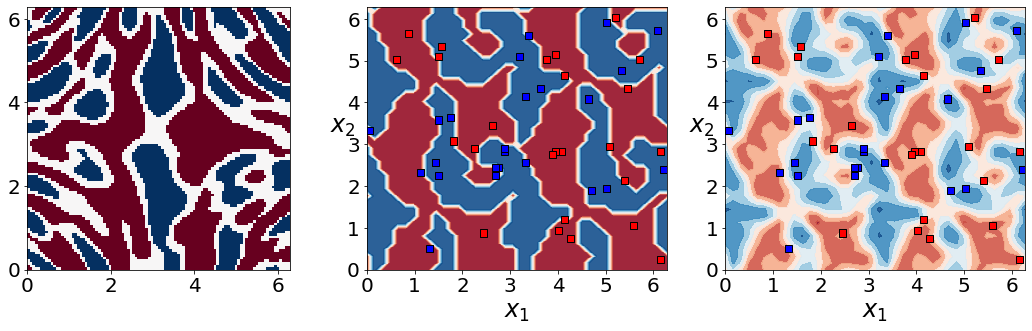

In [159]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=4,
    gates=['RY', 'cz', 'rz', 'rx', ], entanglement='ring',
    repeat=True, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌───┐ ┌──────────────┐ ┌──────────┐                                                                             »
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├─┤ Ry(θ[0]) ├──────■──────────────────────────────────────────────────────────────────────»
     ├───┤ ├──────────────┤ ├──────────┤ ┌────┴─────┐                                                                »
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Ry(θ[1]) ├─┤ Rx(θ[8]) ├─────■──────────────────────────────────────────────────────────»
     ├───┤ ├──────────────┤ ├──────────┤ └──────────┘┌────┴─────┐                                                    »
q_2: ┤ H ├─┤ Rz(2.0*x[0]) ├─┤ Ry(θ[2]) ├─────────────┤ Rx(θ[9]) ├──────■─────────────────────────────────────────────»
     ├───┤ ├──────────────┤ ├──────────┤             └──────────┘┌─────┴─────┐                                       »
q_3: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Ry(θ[3]) ├─────────────────────────┤ Rx(θ[10]) ├──────■────────────────────────────────»
     ├───┤ ├──────────────┤ ├──────────┤        

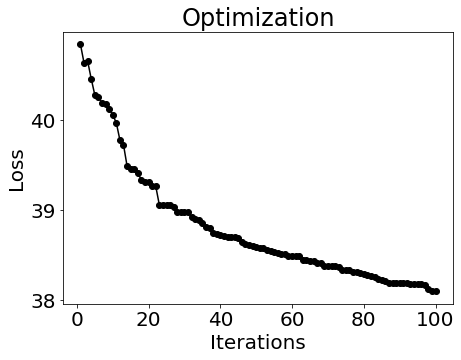


Train scores:
   Balanced accuracy:  0.95
                  F1:  0.95
             ROC_AUC:  0.99
                 MCC:  0.90

Test scores:
   Balanced accuracy:  0.76
                  F1:  0.76
             ROC_AUC:  0.85
                 MCC:  0.52


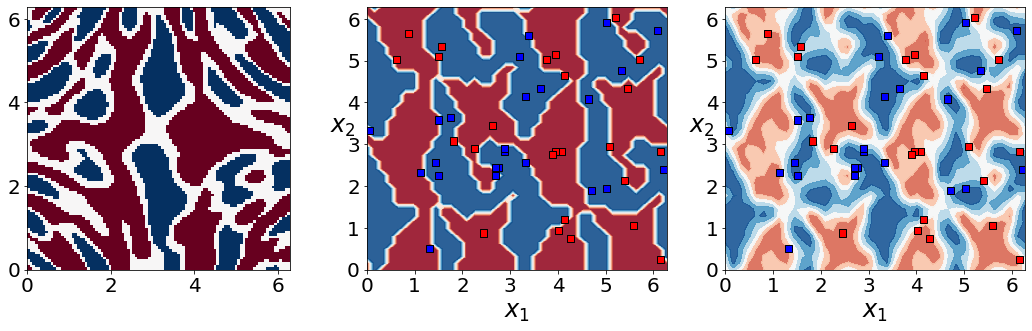

In [160]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=4,
    gates=['H', 'RZ', 'ry', 'crx', ], entanglement='ring',
    repeat=True, scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

     ┌───┐ ┌──────────────┐                                                                                 »
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├────────■────────────────────────────────────────────────────────────────────────»
     ├───┤ ├──────────────┤ ┌──────┴───────┐                                                                »
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Rz(2.0*x[0]) ├───────■────────────────────────────────────────────────────────»
     ├───┤ ├──────────────┤ └──────────────┘┌──────┴───────┐                                                »
q_2: ┤ H ├─┤ Rz(2.0*x[0]) ├─────────────────┤ Rz(2.0*x[1]) ├───────■────────────────────────────────────────»
     ├───┤ ├──────────────┤                 └──────────────┘┌──────┴───────┐                                »
q_3: ┤ H ├─┤ Rz(2.0*x[1]) ├─────────────────────────────────┤ Rz(2.0*x[0]) ├───────■────────────────────────»
     ├───┤ ├──────────────┤                                 └──────────────┘┌──────┴───────┐                »
q_4: ┤ H ├

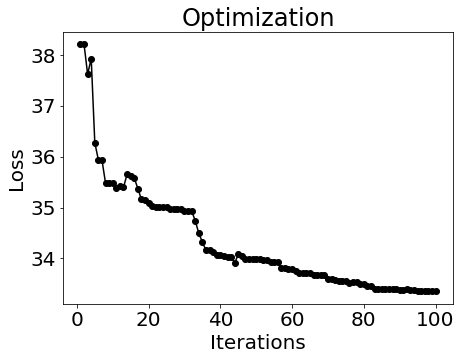


Train scores:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.98

Test scores:
   Balanced accuracy:  0.84
                  F1:  0.84
             ROC_AUC:  0.92
                 MCC:  0.68


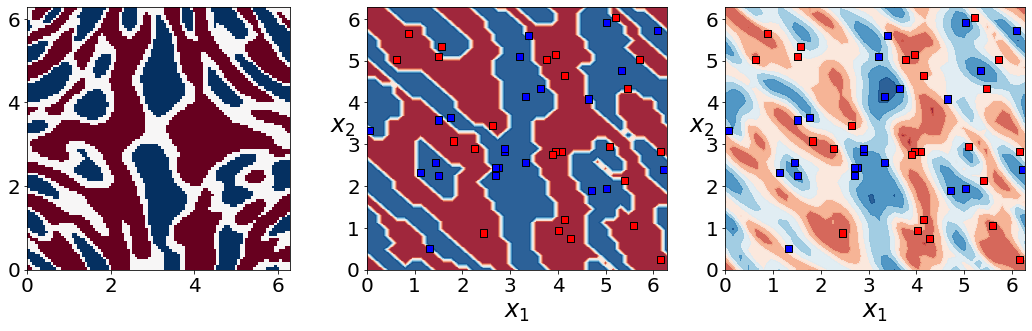

In [161]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['H', 'RZ', 'CRZ', 'ry' ], entanglement='ring',
    repeat=True, scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=100,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

# Cross-Validation

     ┌───┐ ┌────────────┐ ┌──────────┐                                                                       »
q_0: ┤ H ├─┤ Rz(x[0]*α) ├─┤ Ry(θ[0]) ├───────■───────────────────────────────────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤ ┌─────┴──────┐                                                        »
q_1: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Ry(θ[1]) ├─┤ Rz(x[0]*α) ├──────■─────────────────────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤ └────────────┘┌─────┴──────┐                                          »
q_2: ┤ H ├─┤ Rz(x[0]*α) ├─┤ Ry(θ[2]) ├───────────────┤ Rz(x[1]*α) ├──────■───────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤               └────────────┘┌─────┴──────┐                            »
q_3: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Ry(θ[3]) ├─────────────────────────────┤ Rz(x[0]*α) ├──────■─────────────────────»
     ├───┤ ├────────────┤ ├──────────┤                             └────────────┘┌─────┴──────┐              »
q

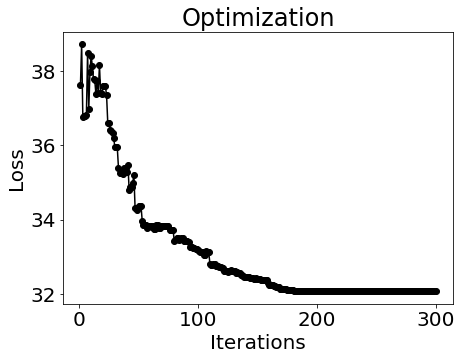


Train scores:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.98

Test scores:
   Balanced accuracy:  0.88
                  F1:  0.88
             ROC_AUC:  0.92
                 MCC:  0.76


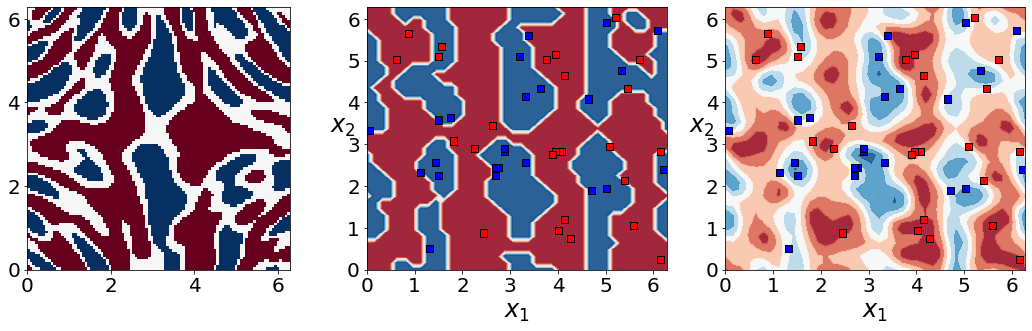

In [162]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['H', 'RZ', 'ry', 'CRZ'], entanglement='ring',
    repeat=True,
)

print(fm.draw(plot_barriers=False, fold=120))

fm.assign_parameters({fm.alpha: 2.0}, inplace=True)

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=300,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

In [163]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

_train_size = 100
_test_size = 50
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=_train_size, test_size=_test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        # qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=1, random_state=_seed)
        # qsvc.fit(X[train,:], y[train])

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.94

Train set:
   Balanced accuracy:  0.86 +- 0.02
                  F1:  0.86 +- 0.02
             ROC_AUC:  0.94 +- 0.02
                 MCC:  0.71 +- 0.05

Test set:
   Balanced accuracy:  0.85 +- 0.04
                  F1:  0.85 +- 0.04
             ROC_AUC:  0.94 +- 0.03
                 MCC:  0.70 +- 0.09


     ┌───┐ ┌────────────┐ ┌──────────┐                                                                       »
q_0: ┤ H ├─┤ Rz(x[0]*α) ├─┤ Ry(θ[0]) ├───────■───────────────────────────────────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤ ┌─────┴──────┐                                                        »
q_1: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Ry(θ[1]) ├─┤ Rz(x[0]*α) ├──────■─────────────────────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤ └────────────┘┌─────┴──────┐                                          »
q_2: ┤ H ├─┤ Rz(x[0]*α) ├─┤ Ry(θ[2]) ├───────────────┤ Rz(x[1]*α) ├──────■───────────────────────────────────»
     ├───┤ ├────────────┤ ├──────────┤               └────────────┘┌─────┴──────┐                            »
q_3: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Ry(θ[3]) ├─────────────────────────────┤ Rz(x[0]*α) ├──────■─────────────────────»
     ├───┤ ├────────────┤ ├──────────┤                             └────────────┘┌─────┴──────┐              »
q

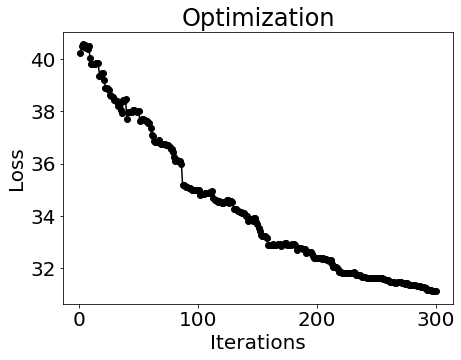


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.86
                  F1:  0.86
             ROC_AUC:  0.94
                 MCC:  0.72


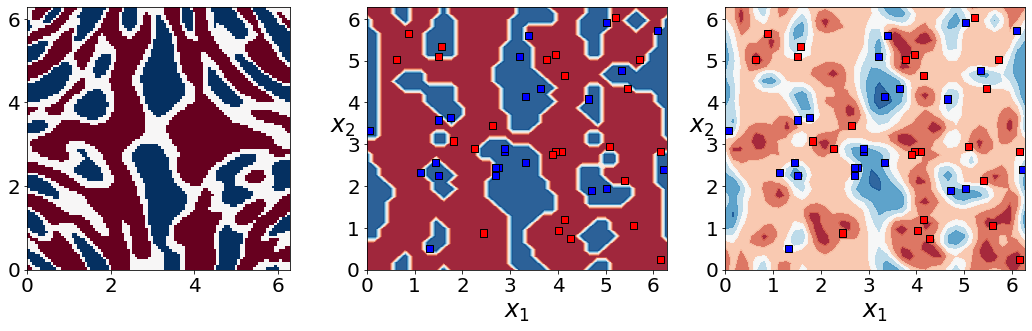

In [164]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=4,
    gates=['H', 'RZ', 'ry', 'CRZ'], entanglement='ring',
    repeat=True,
)

print(fm.draw(plot_barriers=False, fold=120))

fm.assign_parameters({fm.alpha: 2.0}, inplace=True)

qsvc = QSVM_QKT(
    fm, X_train, y_train, maxiter=300,
    verbose=False, plot=True, seed=seed
)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)

In [165]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

_train_size = 100
_test_size = 50
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=_train_size, test_size=_test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        # qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=1, random_state=_seed)
        # qsvc.fit(X[train,:], y[train])

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.96

Train set:
   Balanced accuracy:  0.85 +- 0.03
                  F1:  0.85 +- 0.03
             ROC_AUC:  0.94 +- 0.02
                 MCC:  0.70 +- 0.06

Test set:
   Balanced accuracy:  0.83 +- 0.04
                  F1:  0.83 +- 0.04
             ROC_AUC:  0.93 +- 0.03
                 MCC:  0.67 +- 0.08
